In [ ]:
# pip install opencv-python opencv-contrib-python

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import os,cv2,keras

In [2]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [7]:
path = "/content/drive/MyDrive/R_CNN_SCRATCH/Images"
annot = "/content/drive/MyDrive/R_CNN_SCRATCH/Airplanes_Annotations"

In [8]:
# Visualizing the images

airplane_081.jpg


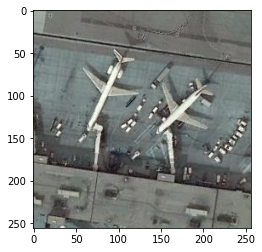

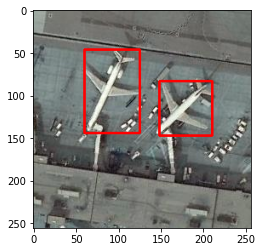

In [9]:
for e,i in enumerate(os.listdir(annot)):  # going through all the files in the annot folder
    file_name = i.split('.')[0]+'.jpg'
    print(file_name)
    img = cv2.imread(os.path.join(path,file_name))  # original image
    df = pd.read_csv(os.path.join(annot,i)) # annotations are provided to mark the areas where object is present and to be detected
    plt.imshow(img)
    for rows in df.iterrows():  # going through all the 
        # rows[0] specify the index of the rows
        x1 = int(rows[1][0].split(" ")[0])  # getting the coordinates
        y1 = int(rows[1][0].split(" ")[1])
        x2 = int(rows[1][0].split(" ")[2])
        y2 = int(rows[1][0].split(" ")[3])
        cv2.rectangle(img,(x1,y1),(x2,y2),(255,0,0),2)  # creating the bounding boxes here 1 is the thickness of the bounding box
    plt.figure()
    plt.imshow(img)
    break


In [10]:
# Creating Selective Search Segmentation

In [11]:
cv2.setUseOptimized(True)
ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()

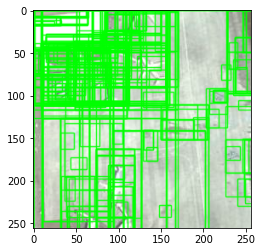

In [12]:
# using selective search segmentation to create segments on the image
# Looking through a single image
im = cv2.imread(os.path.join(path,'airplane_024.jpg'))
ss.setBaseImage(im)
ss.switchToSelectiveSearchFast()  # less number of bounding boxes as compared to ss.switchToSelectiveSearchQuality()
rec_coord = ss.process()
imout = im.copy()
for i, rec in enumerate(rec_coord):
  x,y,w,h = rec
  cv2.rectangle(imout,(x,y),(x+w,y+h),(0,255,0),1,cv2.LINE_AA)
plt.imshow(imout)

In [13]:
# Preparing the training set 
# 1 contains image of plane # 0 contains no plane in the image
train_images1 = []
train_labels1 = []
train_images0 = []
train_labels0 = []

In [14]:
# for finding the intersection over union value of the segments created

In [15]:
def get_iou(seg1,seg2): 
    assert seg1['x1']<seg1['x2']
    assert seg1['y1']<seg1['y2']
    assert seg2['x1']<seg2['x2']
    assert seg2['y1']<seg2['y2']

    x_left = max(seg1['x1'],seg2['x1'])
    x_right = min(seg1['x2'],seg2['x2'])
    y_top = max(seg1['y1'],seg2['y1'])
    y_bottom = min(seg1['y2'],seg2['y2'])

    if x_right<x_left or y_top>y_bottom:
        return 0.0

    intersection_area = (x_right-x_left)*(-y_top+y_bottom)

    seg1_area = (seg1['x2']-seg1['x1'])*(seg1['y2']-seg1['y1'])
    seg2_area = (seg2['x2']-seg2['x1'])*(seg2['y2']-seg2['y1'])

    iou = intersection_area/float(seg1_area+seg2_area-intersection_area)
    assert iou>=0.0
    assert iou<=1.0

    return iou

In [16]:
ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()

In [17]:
for e,i in enumerate(os.listdir(annot)):
    try:
#     if e == 1000:
#       break
        if i.startswith("airplane"):
            filename = i.split(".")[0]+".jpg"
            print(e,filename)
            image = cv2.imread(os.path.join(path,filename))
            df = pd.read_csv(os.path.join(annot,i))
            gtvalues=[]
            for row in df.iterrows():
                x1 = int(row[1][0].split(" ")[0])
                y1 = int(row[1][0].split(" ")[1])
                x2 = int(row[1][0].split(" ")[2])
                y2 = int(row[1][0].split(" ")[3])
                gtvalues.append({"x1":x1,"x2":x2,"y1":y1,"y2":y2})
            ss.setBaseImage(image)
            ss.switchToSelectiveSearchFast()
            ssresults = ss.process()
            imout = image.copy()
            counter = 0
            falsecounter = 0
            flag = 0
            fflag = 0
            bflag = 0
            for e,result in enumerate(ssresults):
                if e < 2000 and flag == 0:
                  for gtval in gtvalues:
                      x,y,w,h = result
                      iou = get_iou(gtval,{"x1":x,"x2":x+w,"y1":y,"y2":y+h})
                      if counter < 50:
                          if iou > 0.85:
                              timage = imout[y:y+h,x:x+w]
                              # timage = imout[x:x+w,y:y+h]
                              resized = cv2.resize(timage, (224,224), interpolation = cv2.INTER_AREA)
                              train_images1.append(resized)
                              train_labels1.append(1)
                              counter += 1
                      else :
                          fflag =1
                      if falsecounter <50:
                          if iou < 0.3:
                              timage = imout[y:y+h,x:x+w]
                              # timage = imout[x:x+w,y:y+h]
                              resized = cv2.resize(timage, (224,224), interpolation = cv2.INTER_AREA)
                              train_images0.append(resized)
                              train_labels0.append(0)
                              falsecounter += 1
                      else :
                          bflag = 1
                if fflag == 1 and bflag == 1:
                    flag = 1
    except Exception as e:
        print(e)
        print("error in "+filename)
        break
    continue


0 airplane_081.jpg
1 airplane_086.jpg
2 airplane_070.jpg
3 airplane_084.jpg
4 airplane_049.jpg
5 airplane_046.jpg
6 airplane_033.jpg
7 airplane_077.jpg
8 airplane_030.jpg
9 airplane_095.jpg
10 airplane_093.jpg
11 airplane_074.jpg
12 airplane_089.jpg
13 airplane_059.jpg
14 airplane_027.jpg
15 airplane_025.jpg
16 airplane_085.jpg
17 airplane_022.jpg
18 airplane_041.jpg
19 airplane_062.jpg
20 airplane_080.jpg
21 airplane_073.jpg
22 airplane_054.jpg
23 airplane_035.jpg
24 airplane_090.jpg
25 airplane_082.jpg
26 airplane_038.jpg
27 airplane_043.jpg
28 airplane_094.jpg
29 airplane_076.jpg
30 airplane_075.jpg
31 airplane_067.jpg
32 airplane_019.jpg
33 airplane_078.jpg
34 airplane_087.jpg
35 airplane_088.jpg
36 airplane_079.jpg
37 airplane_057.jpg
38 airplane_092.jpg
39 airplane_083.jpg
40 airplane_051.jpg
41 airplane_065.jpg
42 airplane_072.jpg
43 airplane_091.jpg
45 airplane_001.jpg
46 airplane_058.jpg
47 airplane_069.jpg
48 airplane_071.jpg
49 airplane_034.jpg
50 airplane_003.jpg
51 airplan

In [18]:
X_new1 = train_images1
Y_new1 = train_labels1
X_new0 = train_images0
Y_new0 = train_labels0

In [19]:
len(Y_new1),len(Y_new0)

(2051, 34900)

In [20]:
# For having same number of images of both types (with/without plane)
X_new = X_new1[:]
X_new += X_new0[:2051]
Y_new = Y_new1[:]
Y_new += Y_new0[:2051]

1


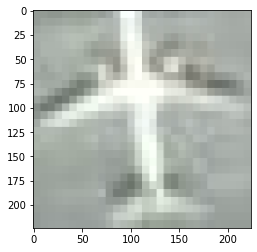

In [21]:
plt.imshow(X_new[543])
print(Y_new[543])

In [22]:
len(X_new),len(Y_new)

(4102, 4102)

In [23]:
X_new = np.array(X_new)
Y_new = np.array(Y_new)

In [24]:
X_new.shape,Y_new.shape

((4102, 224, 224, 3), (4102,))

In [25]:
np.save('X_new.npy',X_new)
np.save('Y_new.npy',Y_new)